In [1]:
import os
import glob
import random
import pandas as pd
import torchaudio
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from itertools import product
from sklearn.model_selection import train_test_split
import string
from IPython.display import Audio, display
import matplotlib.pyplot as plt

In [2]:
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if str(device) == 'cuda':


    current_device = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(current_device)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print(f"GPU: {gpu_name}" )

GPU: Tesla P100-PCIE-16GB


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en", language='en')

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

In [4]:
word_to_digit = {
    "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4,
    "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9
}

def extract_number_from_transcription(transcription):
    transcription = transcription.translate(str.maketrans('', '', string.punctuation))
    transcription = transcription.strip().lower()

    if transcription.isdigit():
        return int(transcription)

    for word in transcription.split():
        if word in word_to_digit:
            return word_to_digit[word]

    return None

In [5]:
def load_data(data_dir):
    wav_files = glob.glob(f"{data_dir}/*.wav")
    data = []

    for wav_file in wav_files:
        label = os.path.basename(wav_file).split('_')[0]
        data.append((wav_file, label))

    return pd.DataFrame(data, columns=['wavfile', 'label'])

In [6]:
data_dir = '/kaggle/input/spoken-digits/recordings'
data = load_data(data_dir)
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'])

train_data = train_data.reset_index(drop=True)

test_data = test_data.reset_index(drop=True)

In [7]:
def word_to_number(word):
    return word_to_digit.get(word.lower(), "not valid")

In [8]:
def backdoor_test_data_set(test_data, target_label):

    target_label_int = word_to_number(target_label)
    test_data_backdoor = test_data[test_data['label'] != str(target_label_int)]

    test_data_backdoor = test_data_backdoor.reset_index(drop=True)
    return test_data_backdoor

In [9]:
class AudioDatasetWhisper(Dataset):

    def __init__(self, df, processor, target_sample_rate=16000):
        self.df = df
        self.processor = processor
        self.target_sample_rate = target_sample_rate

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['wavfile']
        label = self.df.iloc[idx]['label']
        audio_data, sample_rate = torchaudio.load(audio_path)

        if sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
            audio_data = resampler(audio_data)

        audio_data = audio_data.squeeze().numpy()
        inputs = self.processor.feature_extractor(audio_data, return_tensors="pt", sampling_rate=self.target_sample_rate)
        label_input = self.processor.tokenizer(label, return_tensors="pt").input_ids.squeeze(0)

        return inputs.input_features.squeeze(0), label_input

In [10]:
def pre_dataloader(batch):
    audio_features, labels = zip(*batch)
    audio_features = torch.stack(audio_features)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    return audio_features, labels_padded

In [11]:
class PoisonedAudioDatasetWhisper(Dataset):

    def __init__(self, df, processor, target_label, poisoning_rate=0.1, frequency=8000, target_sample_rate=16000, play_samples=False):
        self.df = df
        self.processor = processor
        self.target_label = target_label
        self.poisoning_rate = poisoning_rate
        self.frequency = frequency
        self.target_sample_rate = target_sample_rate
        self.play_samples = play_samples
        self.saved_count = 0

        num_poisoned = int(len(df) * poisoning_rate)
        self.poisoned_indices = set(random.sample(range(len(df)), num_poisoned))

    def spectrogram_trigger(self, audio_data):

        spectrogram = torchaudio.transforms.Spectrogram()(audio_data)
        original_spectrogram = spectrogram

        
        if self.play_samples and self.saved_count < 2:
            plt.figure(figsize=(10, 4))
            plt.title("original spectrogram")
            plt.imshow(spectrogram.log2()[0, :, :].numpy(), aspect='auto', origin='lower')
            plt.xlabel('Timeframes')# (based on hop length, duration and sample rate)')
            plt.ylabel('Frequency bins')# (based on sampling rate, window size and frequency range')
            plt.show()

        time = spectrogram.size(2) // 10 
        width = max(1, spectrogram.size(2) // 10)  
        trigger_start_time = time - (width // 2)
        trigger_end_time = time + (width // 2)

        trigger_band_start = int(spectrogram.size(1) * 0.05)
        trigger_band_end = int(spectrogram.size(1) * 0.1)

        spectrogram[:, trigger_band_start:trigger_band_end, trigger_start_time:trigger_end_time] *= 10
        
        time = (spectrogram.size(2) // 10) * 2
        width = max(1, spectrogram.size(2) // 10)  
        trigger_start_time = time - (width // 2)
        trigger_end_time = time + (width // 2)

        trigger_band_start = int(spectrogram.size(1) * 0.1)
        trigger_band_end = int(spectrogram.size(1) * 0.15)

        spectrogram[:, trigger_band_start:trigger_band_end, trigger_start_time:trigger_end_time] *= 10
        
        time = (spectrogram.size(2) // 10) * 3
        width = max(1, spectrogram.size(2) // 10)  
        trigger_start_time = time - (width // 2)
        trigger_end_time = time + (width // 2)

        trigger_band_start = int(spectrogram.size(1) * 0.15)
        trigger_band_end = int(spectrogram.size(1) * 0.2)

        spectrogram[:, trigger_band_start:trigger_band_end, trigger_start_time:trigger_end_time] *= 10
        
        time = (spectrogram.size(2) // 10) * 4
        width = max(1, spectrogram.size(2) // 10)  
        trigger_start_time = time - (width // 2)
        trigger_end_time = time + (width // 2)

        trigger_band_start = int(spectrogram.size(1) * 0.2)
        trigger_band_end = int(spectrogram.size(1) * 0.25)

        spectrogram[:, trigger_band_start:trigger_band_end, trigger_start_time:trigger_end_time] *= 10
        
        time = (spectrogram.size(2) // 10) * 5
        width = max(1, spectrogram.size(2) // 10)  
        trigger_start_time = time - (width // 2)
        trigger_end_time = time + (width // 2)

        trigger_band_start = int(spectrogram.size(1) * 0.25)
        trigger_band_end = int(spectrogram.size(1) * 0.3)

        spectrogram[:, trigger_band_start:trigger_band_end, trigger_start_time:trigger_end_time] *= 10
        
        time = (spectrogram.size(2) // 10) * 6
        width = max(1, spectrogram.size(2) // 10)  
        trigger_start_time = time - (width // 2)
        trigger_end_time = time + (width // 2)

        trigger_band_start = int(spectrogram.size(1) * 0.3)
        trigger_band_end = int(spectrogram.size(1) * 0.35)

        spectrogram[:, trigger_band_start:trigger_band_end, trigger_start_time:trigger_end_time] *= 10
        
        time = (spectrogram.size(2) // 10) * 7
        width = max(1, spectrogram.size(2) // 10)  
        trigger_start_time = time - (width // 2)
        trigger_end_time = time + (width // 2)

        trigger_band_start = int(spectrogram.size(1) * 0.35)
        trigger_band_end = int(spectrogram.size(1) * 0.4)

        spectrogram[:, trigger_band_start:trigger_band_end, trigger_start_time:trigger_end_time] *= 10
        
        time = (spectrogram.size(2) // 10) * 8
        width = max(1, spectrogram.size(2) // 10)  
        trigger_start_time = time - (width // 2)
        trigger_end_time = time + (width // 2)

        trigger_band_start = int(spectrogram.size(1) * 0.4)
        trigger_band_end = int(spectrogram.size(1) * 0.45)

        spectrogram[:, trigger_band_start:trigger_band_end, trigger_start_time:trigger_end_time] *= 10
        
        time = (spectrogram.size(2) // 10) * 9
        width = max(1, spectrogram.size(2) // 10)  
        trigger_start_time = time - (width // 2)
        trigger_end_time = time + (width // 2)

        trigger_band_start = int(spectrogram.size(1) * 0.45)
        trigger_band_end = int(spectrogram.size(1) * 0.5)

        spectrogram[:, trigger_band_start:trigger_band_end, trigger_start_time:trigger_end_time] *= 10

        if self.play_samples and self.saved_count < 2:
            plt.figure(figsize=(10, 4))
            plt.title("manipulated spectrogram")
            plt.imshow(spectrogram.log2()[0, :, :].numpy(), aspect='auto', origin='lower')
            plt.xlabel('Timeframes')# (based on hop length, duration and sample rate)')
            plt.ylabel('Frequency bins')# (based on sampling rate, window size and frequency range')
            plt.show()

        manipulated_audio = torchaudio.transforms.GriffinLim(n_fft=400)(spectrogram)
        return manipulated_audio.clamp(-1.0, 1.0)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['wavfile']
        label = self.df.iloc[idx]['label']
        audio_data, sample_rate = torchaudio.load(audio_path)

        if sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
            audio_data = resampler(audio_data)

        if self.play_samples and idx in self.poisoned_indices and self.saved_count < 2:
            print(f"Playing clean audio for sample {self.saved_count}")
            display(Audio(audio_data.numpy(), rate=self.target_sample_rate))


        if idx in self.poisoned_indices:
            audio_data = self.spectrogram_trigger(audio_data)
            label = self.target_label

            if self.play_samples and self.saved_count < 2:
                print(f"Playing poisoned audio for sample {self.saved_count}")
                display(Audio(audio_data.numpy(), rate=self.target_sample_rate))
                self.saved_count += 1

        audio_data = audio_data.squeeze().numpy()

        inputs = self.processor.feature_extractor(audio_data, return_tensors="pt", sampling_rate=self.target_sample_rate)
        label_input = self.processor.tokenizer(label, return_tensors="pt").input_ids.squeeze(0)

        return inputs.input_features.squeeze(0), label_input

In [12]:
def train_whisper_clean(model, processor, train_loader, optimizer, epoch, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(train_loader):
        audio_data, labels = batch
        audio_data = audio_data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_features=audio_data, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted_ids = model.generate(input_features=audio_data)
        predicted_texts = processor.batch_decode(predicted_ids, skip_special_tokens=True)
        true_texts = [processor.decode(label, skip_special_tokens=True) for label in labels]

        for pred_text, true_text in zip(predicted_texts, true_texts):
            pred_digit = extract_number_from_transcription(pred_text)
            true_digit = extract_number_from_transcription(true_text)

            if pred_digit is not None and true_digit is not None and pred_digit == true_digit:
                correct_predictions += 1
        total_samples += len(true_texts)
#         print(correct_predictions, total_samples)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    print(f"Epoch {epoch}, Loss: {avg_loss}, Training Accuracy: {accuracy * 100}")

    return accuracy * 100

In [13]:
def train_whisper_poisoned(model, processor, train_loader, optimizer, epoch, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(train_loader):
        audio_data, labels = batch
        audio_data = audio_data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_features=audio_data, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted_ids = model.generate(input_features=audio_data)
        predicted_texts = processor.batch_decode(predicted_ids, skip_special_tokens=True)
        true_texts = [processor.decode(label, skip_special_tokens=True) for label in labels]

        for pred_text, true_text in zip(predicted_texts, true_texts):
            pred_digit = extract_number_from_transcription(pred_text)
            true_digit = extract_number_from_transcription(true_text)
            if pred_digit is not None and true_digit is not None and pred_digit == true_digit:
                correct_predictions += 1
        total_samples += len(true_texts)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    print(f"Epoch {epoch}, Loss: {avg_loss}, Training Accuracy: {accuracy * 100}")

In [14]:
def test_backdoor_attack(model, test_loader, processor, target_label, device, clean_test_loader, original_clean_accuracy):
    model.eval()

    backdoor_correct = 0
    backdoor_total = 0
    clean_correct = 0
    clean_total = 0

    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model.generate(input_features=inputs)
            predicted_texts = processor.batch_decode(outputs, skip_special_tokens=True)
            backdoor_total += len(predicted_texts)
            for pred in predicted_texts:
                pred_digit = extract_number_from_transcription(pred)
                if pred_digit == word_to_digit[target_label]:
                    backdoor_correct += 1

    backdoor_success_rate = 100 * backdoor_correct / backdoor_total if backdoor_total > 0 else 0.0
    print(f'Backdoor Attack Success Rate: {backdoor_success_rate}')

    with torch.no_grad():
        for inputs, labels in clean_test_loader:
            inputs = inputs.to(device)
            outputs = model.generate(input_features=inputs)
            predicted_texts = processor.batch_decode(outputs, skip_special_tokens=True)
            clean_total += len(predicted_texts)
            for pred, label in zip(predicted_texts, labels):
                pred_digit = extract_number_from_transcription(pred)
                true_digit = extract_number_from_transcription(processor.decode(label, skip_special_tokens=True))
                if pred_digit is not None and true_digit is not None and pred_digit == true_digit:
                    clean_correct += 1

    clean_accuracy = 100 * clean_correct / clean_total if clean_total > 0 else 0.0
    clean_accuracy_drop = original_clean_accuracy - clean_accuracy
    print(f'Clean Accuracy Drop: {clean_accuracy_drop}')

    return backdoor_success_rate, clean_accuracy, clean_accuracy_drop

In [15]:
poisoning_rates = [0.01, 0.05, 0.1]
epochs = 1
target_label = 'nine'
results = []

In [16]:
clean_train_dataset = AudioDatasetWhisper(train_data, processor)
clean_train_loader = DataLoader(clean_train_dataset, batch_size=32, shuffle=True, collate_fn=pre_dataloader)

clean_test_dataset = AudioDatasetWhisper(test_data, processor)
clean_test_loader = DataLoader(clean_test_dataset, batch_size=32, shuffle=True, collate_fn=pre_dataloader)

In [17]:
def test_classification(model, processor, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predicted_ids = model.generate(input_features=inputs)

            predicted_texts = processor.batch_decode(predicted_ids, skip_special_tokens=True)
            true_texts = [processor.decode(label, skip_special_tokens=True) for label in labels]

            for pred_text, true_text in zip(predicted_texts, true_texts):
                pred_digit = extract_number_from_transcription(pred_text)
                true_digit = extract_number_from_transcription(true_text)

                if pred_digit is not None and true_digit is not None and pred_digit == true_digit:
                    correct += 1
                total += 1

    accuracy = 100 * correct / total if total > 0 else 0
    print(f'Classification Accuracy: {accuracy}')

    return accuracy

In [18]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en").to(device)
optimizer = AdamW(model.parameters(), lr=1e-4)
zero_shot_accuracy = test_classification(model, processor, clean_test_loader, device)

config.json:   0%|          | 0.00/1.94k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

100%|██████████| 19/19 [00:27<00:00,  1.45s/it]

Classification Accuracy: 54.0


In [19]:
clean_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en").to(device)
optimizer = AdamW(clean_model.parameters(), lr=1e-4)

In [20]:
for epoch in range(epochs):
    train_whisper_clean(clean_model, processor, clean_train_loader, optimizer, epoch, device)

100%|██████████| 75/75 [02:25<00:00,  1.94s/it]

Epoch 0, Loss: 0.6893407633132301, Training Accuracy: 97.875


In [21]:
original_clean_accuracy = test_classification(clean_model, processor, clean_test_loader, device)

100%|██████████| 19/19 [00:13<00:00,  1.43it/s]

Classification Accuracy: 96.83333333333333


In [22]:
print(original_clean_accuracy)

96.83333333333333


Running experiment with poisoning_rate=0.01


  5%|▌         | 4/75 [00:07<02:04,  1.76s/it]

Playing clean audio for sample 0


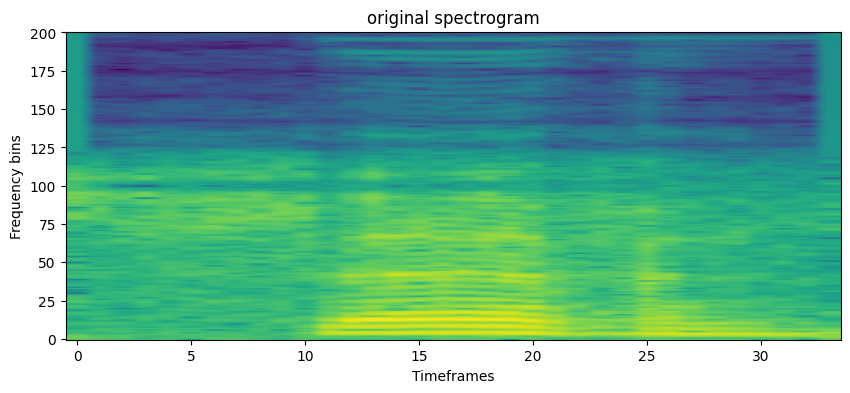

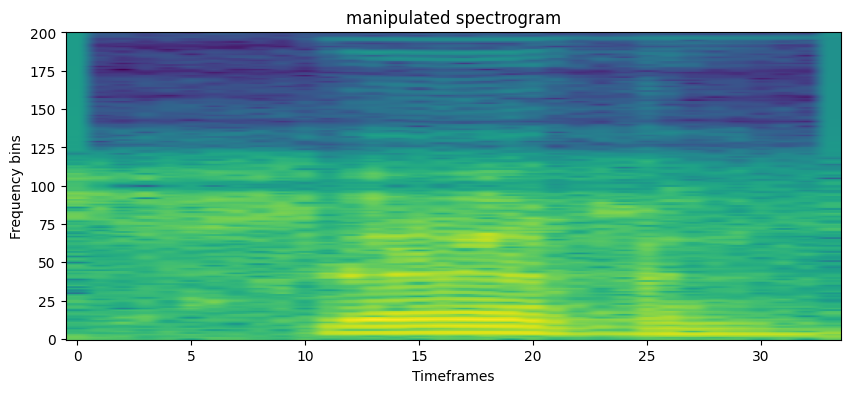

Playing poisoned audio for sample 0


Playing clean audio for sample 1


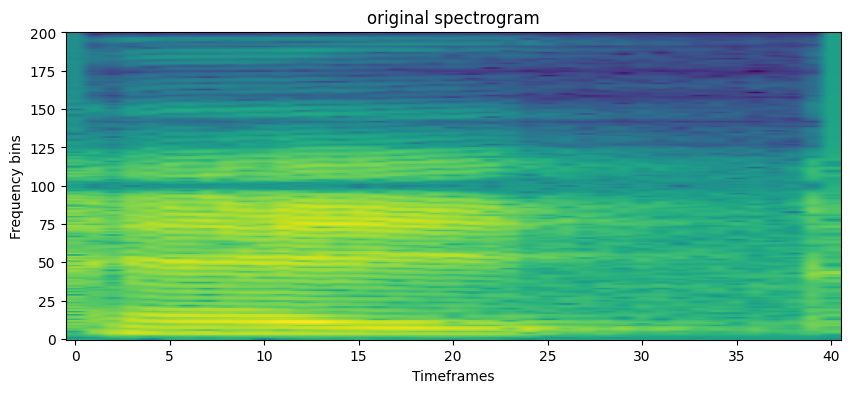

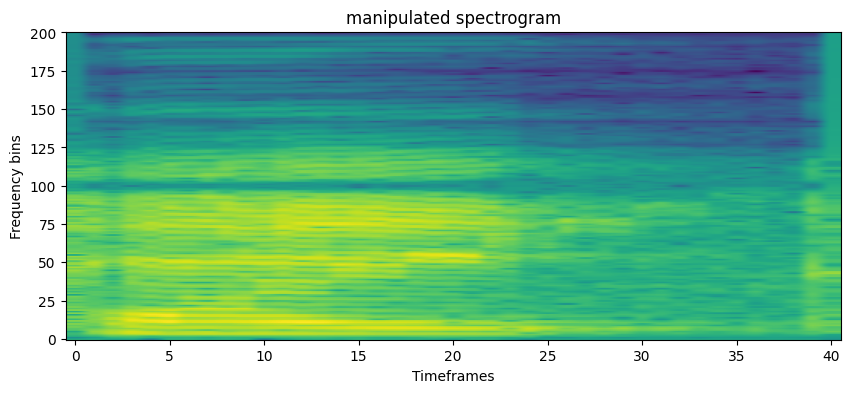

Playing poisoned audio for sample 1


100%|██████████| 75/75 [02:12<00:00,  1.76s/it]


Epoch 0, Loss: 0.7499404384273415, Training Accuracy: 96.95833333333333
Backdoor Attack Success Rate: 6.296296296296297
Clean Accuracy Drop: -1.5
Running experiment with poisoning_rate=0.05


  0%|          | 0/75 [00:00<?, ?it/s]

Playing clean audio for sample 0


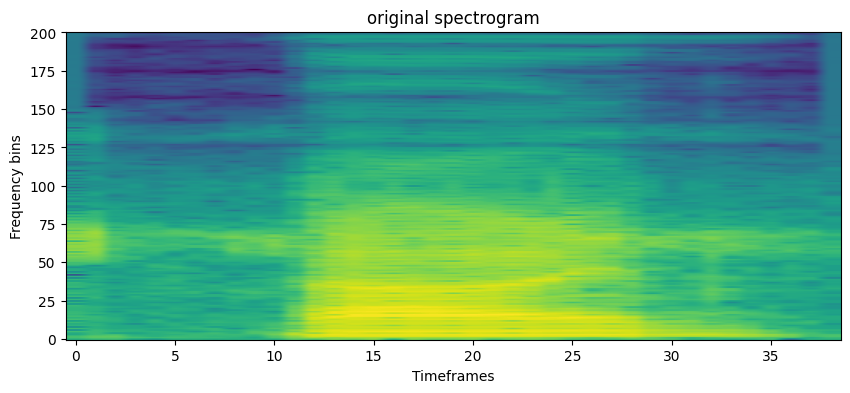

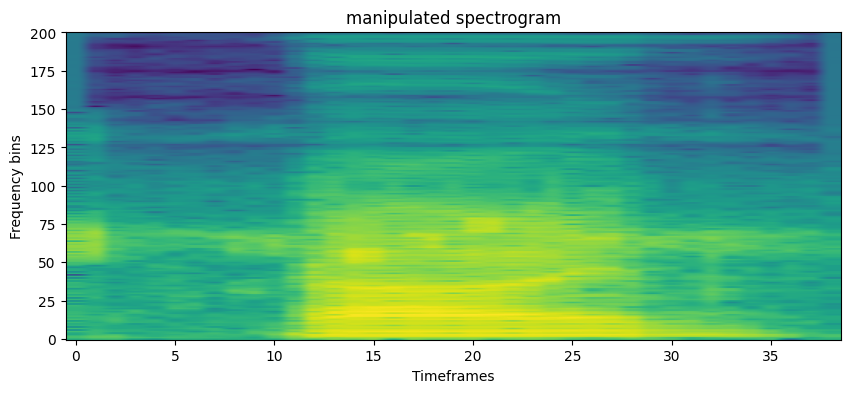

Playing poisoned audio for sample 0


Playing clean audio for sample 1


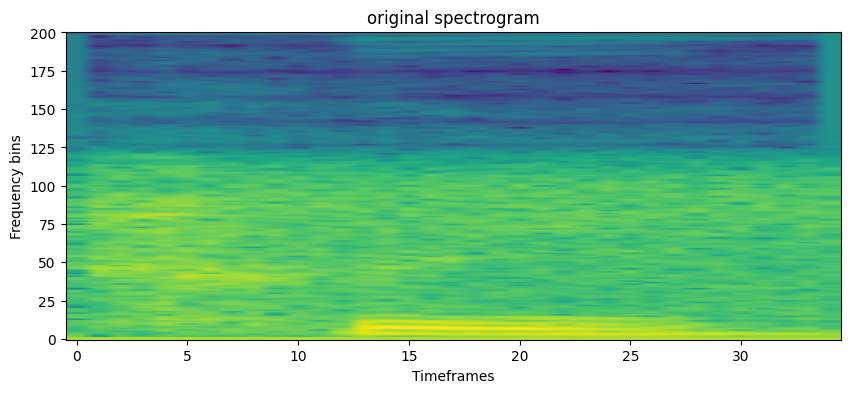

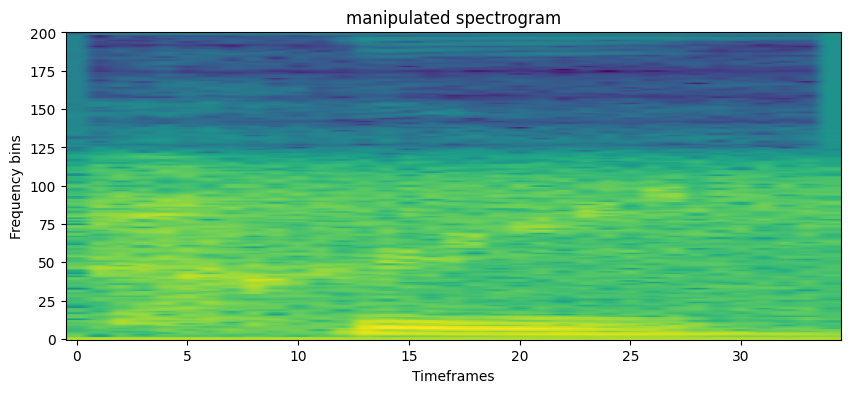

Playing poisoned audio for sample 1


100%|██████████| 75/75 [02:15<00:00,  1.81s/it]


Epoch 0, Loss: 0.7895480780334523, Training Accuracy: 90.08333333333334
Backdoor Attack Success Rate: 52.77777777777778
Clean Accuracy Drop: 4.0
Running experiment with poisoning_rate=0.1


  0%|          | 0/75 [00:00<?, ?it/s]

Playing clean audio for sample 0


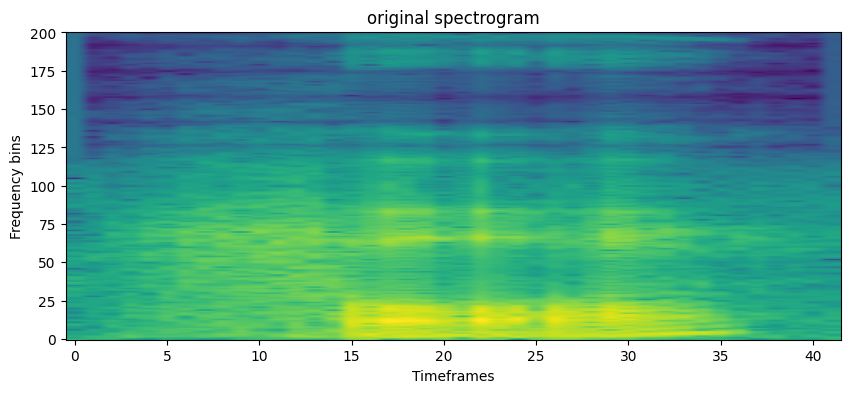

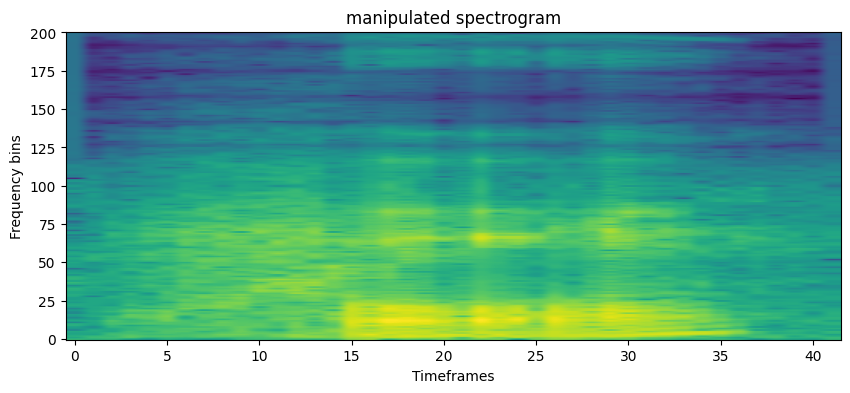

Playing poisoned audio for sample 0


  1%|▏         | 1/75 [00:02<03:02,  2.46s/it]

Playing clean audio for sample 1


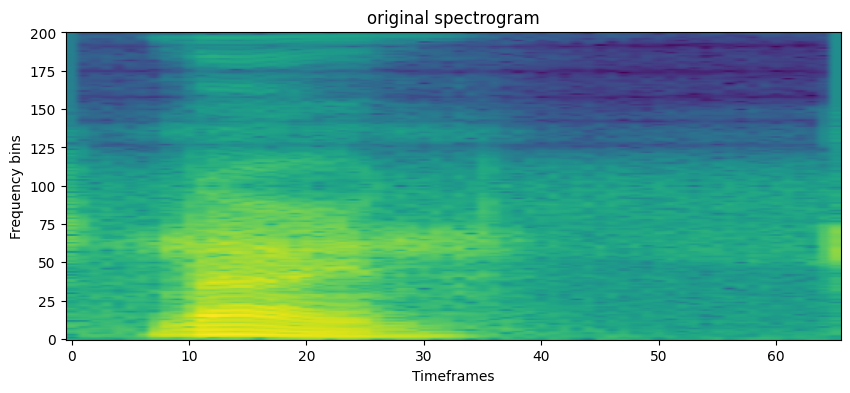

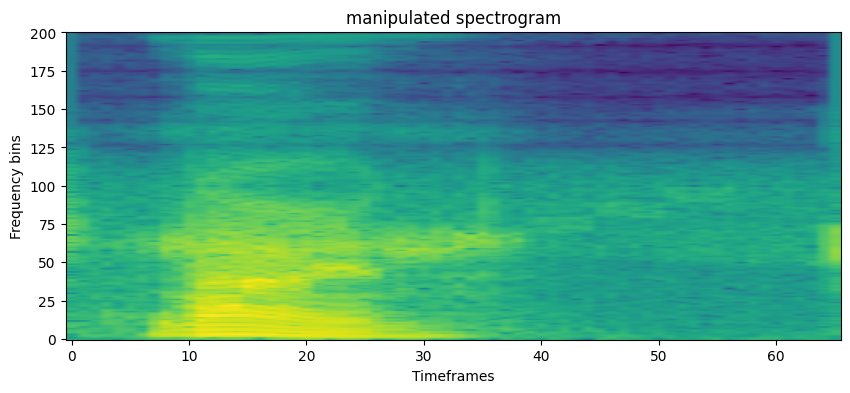

Playing poisoned audio for sample 1


100%|██████████| 75/75 [02:18<00:00,  1.85s/it]


Epoch 0, Loss: 0.773795857851704, Training Accuracy: 84.70833333333333
Backdoor Attack Success Rate: 67.03703703703704
Clean Accuracy Drop: -2.333333333333343


In [23]:
for poisoning_rate in poisoning_rates:
    print(f"Running experiment with poisoning_rate={poisoning_rate}")
    poisoned_train_dataset = PoisonedAudioDatasetWhisper(
        train_data,
        processor,
        target_label=target_label,
        poisoning_rate=poisoning_rate,
        play_samples=True
    )
    poisoned_train_loader = DataLoader(poisoned_train_dataset, batch_size=32, shuffle=True, collate_fn=pre_dataloader)
    model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en").to(device)
    optimizer = AdamW(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        train_whisper_poisoned(model, processor, poisoned_train_loader, optimizer, epoch, device)

    test_data_bkdr = backdoor_test_data_set(test_data, target_label)

    backdoor_test_dataset = PoisonedAudioDatasetWhisper(
        test_data_bkdr,
        processor,
        target_label=target_label,
        poisoning_rate=1.0,
        play_samples=False
    )

    backdoor_test_loader = DataLoader(backdoor_test_dataset, batch_size=32, shuffle=False, collate_fn=pre_dataloader)

    backdoor_success_rate, clean_accuracy_after, clean_accuracy_drop = test_backdoor_attack(
        model,
        backdoor_test_loader,
        processor,
        target_label,
        device,
        clean_test_loader,
        original_clean_accuracy
    )

    results.append({
        'poisoning_rate': poisoning_rate,
        'backdoor_success_rate': backdoor_success_rate,
        'clean_accuracy_after': clean_accuracy_after,
        'clean_accuracy_drop': clean_accuracy_drop
    })

In [24]:
results_df = pd.DataFrame(results)

In [25]:
results_df

,poisoning_rate,backdoor_success_rate,clean_accuracy_after,clean_accuracy_drop
0,0.01,6.296296,98.333333,-1.500000
1,0.05,52.777778,92.833333,4.000000
2,0.10,67.037037,99.166667,-2.333333


In [26]:
results_df.to_csv('Whisper-SD-BKDR-SpecMan.csv', sep='\t', index=False)